In [1]:
"""Data inspection."""

'Data inspection.'

In [42]:
import csv
import glob
import matplotlib
%matplotlib inline
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from matplotlib import animation
import nibabel
import os
import sklearn
import shutil

import torch
import numpy as np
import pickle

import importlib
import datasets
importlib.reload(datasets)
import vis
importlib.reload(vis)

NEURO_DIR = '/neuro/'

IMG_SHAPE = (25, 25)
SHAPE_STR = datasets.get_shape_string(IMG_SHAPE)
train_dataset, val_dataset = datasets.get_dataset_connectomes(img_shape=IMG_SHAPE)

TRAIN_IMG_PATH = '/neuro/train_val_datasets/train_conn_%s.npy' % SHAPE_STR

Loading /neuro/HCP_PTN1200_recon2/netmats/3T_HCP1200_MSMAll_d25_ts2/netmats2.txt...
Saving /neuro/train_val_datasets/train_conn_25x25.npy...
Saving /neuro/train_val_datasets/val_conn_25x25.npy...


From: https://www.humanconnectome.org/storage/app/media/documentation/s1200/HCP_S1200_Release_Reference_Manual.pdf

1. netmats1: Using "full" normalized temporal correlation between every node timeseries
and every other. This is a common approach and is very simple, but it has various
practical and interpretational disadvantages [Smith 2012].
2. netmats2: Using partial temporal correlation between nodes' timeseries. This aims to
estimate direct connection strengths better than achieved by full correlation. To slightly
improve the estimates of partial correlation coefficients, a small amount of L2
regularization is applied (setting rho=0.01 in the Ridge Regression netmats option in
FSLNets) [Smith OHBM 2014, FSLNets]. 

In [43]:
print(train_dataset.shape)
print(np.min(train_dataset))
print(np.max(train_dataset))

(649, 1, 25, 25)
0.0
1.0


Loading /neuro/train_val_datasets/train_conn_25x25.npy
Dataset shape: (649, 1, 25, 25)


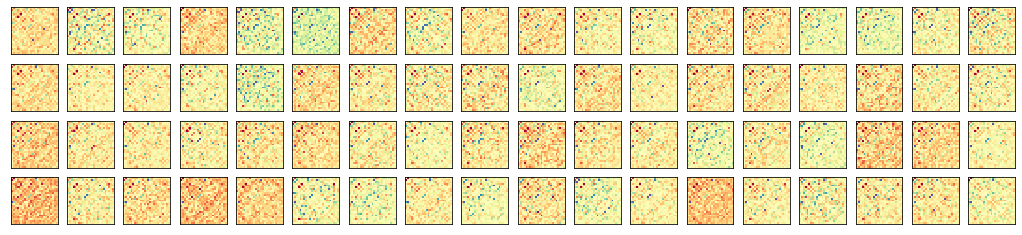

In [44]:
vis.show_data(TRAIN_IMG_PATH, cmap='Spectral')